## 1. Import Library

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna.integration.lightgbm as op_lgb
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

import utils

## 2. Load data

In [176]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
genre = pd.read_csv("../data/genre_labels.csv")

In [177]:
train = train.dropna().reset_index(drop=True)
train = train.drop(["index"], axis=1)
train

,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,121-152,region_P
4032,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
4033,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E
4034,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,77-96,region_R


In [178]:
test = test.drop(["index"], axis=1)
test

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,77-96,region_I
1,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,121-152,unknown
2,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,121-152,region_K
3,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,77-96,region_D
4,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,97-120,region_E
...,...,...,...,...,...,...,...,...,...,...,...,...
4041,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B
4042,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I
4043,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H
4044,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B


In [179]:
genre

,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


## 3. 特徴量エンジニアリング
- Features:
    - tempo: tempo_min, tempo_max, tempo_diff
    - region: one_hot_vecotorにする (unkownのまま)
- train, valid: 8:2でランダムに分割
- Model: light gbm (パラメータチューニングなし)

In [180]:
tempo_train = utils.make_tempo_features(df=train)
tempo_test = utils.make_tempo_features(df=test)

In [181]:
# region_train = utils.make_region_features(df=train)
# region_test = utils.make_region_features(df=test)

# # testには、'region_M'が存在しない
# region_train_columns = region_train.columns.to_numpy()
# region_test_columns = region_test.columns.to_numpy()
# region_only_train = np.array([region_train_column for region_train_column in region_train_columns if region_train_column not in region_test_columns])
# # print(region_only_train) > array(['region_M'], dtype='<U8')

# # 'region_M'の挿入位置を指定
# region_M_index = np.where(region_train_columns == "region_M")[0][0]

# # region_testに、'region_M'を追加
# region_test.insert(int(region_M_index), "region_M", pd.Series(np.zeros(test.shape[0]), dtype="uint8"))

新たに追加
- popularity
    - popularity_001: popularityの1の位の値
    - popularity_010: 10の位の値
- region : regionをkeyにした集約特徴量


In [182]:
# popularity
popularity_train = utils.make_popularity_features(df=train)
popularity_test = utils.make_popularity_features(df=test)

popularity_train

,popularity_01,popularity_10
0,1,1
1,9,6
2,3,4
3,5,4
4,7,5
...,...,...
4031,8,3
4032,3,2
4033,0,3
4034,5,2


In [183]:
# OneHotEncodingではなく、Label Encodingで実験
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train["region"])
train["OE_region"] = le.transform(train["region"])
test["OE_region"] = le.transform(test["region"])
train["OE_region"]

def make_ce_features(df):
    # count encodingした特徴量
    _df = pd.concat([df, make_popularity_features(df)], axis=1)
    cols = ["region", "popularity10"]
    encoder = ce.CountEncoder()
    return encoder.fit_transform(_df[cols]).add_prefix("CE_")

0        7
1        8
2        4
3        2
4       20
        ..
4031    15
4032     3
4033     4
4034    17
4035     4
Name: OE_region, Length: 4036, dtype: int64

In [184]:
# Train + Test
whole_df = pd.concat([train.drop(["genre"], axis=1), test], axis=0).reset_index(drop=True)
whole_df

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,OE_region
0,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H,7
1,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I,8
2,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E,4
3,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C,2
4,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B,1
8078,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I,8
8079,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H,7
8080,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B,1


In [169]:
# regionの集約特徴量
region_agg = utils.make_key_agg(df=whole_df, key="region")

region_agg_train = utils.make_agg_features(df=train.drop(["genre"], axis=1), key="region", key_agg=region_agg)
region_agg_test = utils.make_agg_features(df=test, key="region", key_agg=region_agg)

region_agg_train.head(10)

,agg_min_popularity_groupby_region,agg_mean_popularity_groupby_region,agg_max_popularity_groupby_region,agg_median_popularity_groupby_region,agg_std_popularity_groupby_region,agg_max_min_popularity_groupby_region,agg_q75_q25_popularity_groupby_region,agg_z_score_popularity_groupby_region,agg_min_duration_ms_groupby_region,agg_mean_duration_ms_groupby_region,...,agg_q75_q25_speechiness_groupby_region,agg_z_score_speechiness_groupby_region,agg_min_instrumentalness_groupby_region,agg_mean_instrumentalness_groupby_region,agg_max_instrumentalness_groupby_region,agg_median_instrumentalness_groupby_region,agg_std_instrumentalness_groupby_region,agg_max_min_instrumentalness_groupby_region,agg_q75_q25_instrumentalness_groupby_region,agg_z_score_instrumentalness_groupby_region
0,0.0,33.594805,62.0,41.0,16.577375,62.0,28.00,-1.362908,55429.0,241215.114286,...,0.079243,2.267676,0.066214,0.234180,1.000000,0.178119,0.172665,0.933786,0.070718,3.769920
1,0.0,40.509218,80.0,42.0,16.328317,80.0,23.00,1.744763,6188.0,239207.812460,...,0.084600,-0.494754,0.042803,0.199632,0.896772,0.167948,0.128815,0.853969,0.060090,-0.583302
2,3.0,44.000740,81.0,45.0,15.418010,78.0,20.00,-0.064903,35691.0,247961.070266,...,0.077507,1.957946,0.032990,0.199077,0.895619,0.169010,0.129543,0.862629,0.057726,-0.249781
3,6.0,39.953216,79.0,46.0,15.696689,73.0,15.00,0.321499,37293.0,257904.222222,...,0.078272,0.430669,0.090735,0.215710,0.862155,0.179262,0.137212,0.771420,0.049478,-0.291658
4,0.0,41.011494,81.0,42.0,16.476096,81.0,23.00,0.970347,6506.0,244900.321839,...,0.083831,0.204394,0.036902,0.212711,0.895567,0.173691,0.150883,0.858665,0.063176,0.087693
5,0.0,40.509218,80.0,42.0,16.328317,80.0,23.00,-0.521101,6188.0,239207.812460,...,0.084600,0.336771,0.042803,0.199632,0.896772,0.167948,0.128815,0.853969,0.060090,-0.346445
6,4.0,33.746667,39.0,35.0,5.271272,35.0,3.50,-0.520965,59424.0,239480.306667,...,0.058351,0.646842,0.093328,0.177841,0.493747,0.176769,0.049248,0.400420,0.043708,-0.988326
7,10.0,41.062069,67.0,42.0,15.002524,57.0,22.00,-1.470459,32963.0,233289.700000,...,0.070283,-0.130493,0.060178,0.210734,0.869199,0.168599,0.152931,0.809021,0.068201,-0.484869
8,0.0,38.803571,82.0,40.0,15.469506,82.0,22.25,0.723727,6199.0,254766.787202,...,0.071130,-0.830091,0.049319,0.217183,0.870282,0.174032,0.151030,0.820962,0.064483,-0.128593
9,10.0,41.062069,67.0,42.0,15.002524,57.0,22.00,-1.670412,32963.0,233289.700000,...,0.070283,-0.803192,0.060178,0.210734,0.869199,0.168599,0.152931,0.809021,0.068201,-0.627413


In [150]:
# Category Encodingも追加
import category_encoders as ce
ce_encoder = ce.CountEncoder()
train["CE_region"] = ce_encoder.fit_transform(train["region"]).add_prefix("CE_")
test["CE_region"] = ce_encoder.fit_transform(test["region"]).add_prefix("CE_")
train["CE_region"]

/home/matsunaga/Documents/signate/student-cup-2021-spring/.venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0       181
1       752
2       709
3        84
4       370
       ... 
4031    345
4032    199
4033    709
4034     50
4035    709
Name: CE_region, Length: 4036, dtype: int64

## 4. モデルの学習

In [151]:
# Train
X = train.drop(["genre", "tempo", "region"], axis=1)
# X = pd.concat([X, tempo_train, region_train, popularity_train, region_agg_train], axis=1)
X = pd.concat([X, tempo_train, popularity_train, region_agg_train], axis=1)
y = train["genre"]
X

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,...,agg_q75_q25_speechiness_groupby_region,agg_z_score_speechiness_groupby_region,agg_min_instrumentalness_groupby_region,agg_mean_instrumentalness_groupby_region,agg_max_instrumentalness_groupby_region,agg_median_instrumentalness_groupby_region,agg_std_instrumentalness_groupby_region,agg_max_min_instrumentalness_groupby_region,agg_q75_q25_instrumentalness_groupby_region,agg_z_score_instrumentalness_groupby_region
0,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,...,0.079243,2.267676,0.066214,0.234180,1.000000,0.178119,0.172665,0.933786,0.070718,3.769920
1,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,...,0.084600,-0.494754,0.042803,0.199632,0.896772,0.167948,0.128815,0.853969,0.060090,-0.583302
2,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,...,0.077507,1.957946,0.032990,0.199077,0.895619,0.169010,0.129543,0.862629,0.057726,-0.249781
3,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,...,0.078272,0.430669,0.090735,0.215710,0.862155,0.179262,0.137212,0.771420,0.049478,-0.291658
4,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,...,0.083831,0.204394,0.036902,0.212711,0.895567,0.173691,0.150883,0.858665,0.063176,0.087693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,...,0.070423,-0.082270,0.000000,0.259452,0.909963,0.176907,0.212917,0.909963,0.072901,-0.473338
4032,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,...,0.074665,-0.693322,0.053642,0.243889,0.901344,0.185042,0.175200,0.847702,0.078114,0.293524
4033,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,...,0.077507,-0.555434,0.032990,0.199077,0.895619,0.169010,0.129543,0.862629,0.057726,-0.272662
4034,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,...,0.076918,0.458845,0.098108,0.340174,0.865533,0.199824,0.254966,0.767425,0.318449,-0.507840


In [152]:
# ハイパーパラメータ設定
params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": 'multiclass',
    "num_class": 11,
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "verbosity": -1,
    "seed": 42,
}

# Training model
# Use stratified k fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for cv_num, (train_index, valid_index) in enumerate(kf.split(X, y, y)):
    # cv
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    # make dataset
    trains = lgb.Dataset(X_train, label=y_train)
    valids = lgb.Dataset(X_valid, label=y_valid)
    
    # train
    model = lgb.train(params, trains, valid_sets=valids,
                     verbose_eval=False,
                     num_boost_round=10000,
                     early_stopping_rounds=100)
    
    y_pred = model.predict(X_valid).argmax(1)
    score = f1_score(y_valid, y_pred, average='macro')
    cv_scores.append(score)
    print(f"Folds: {cv_num}, val_score: {score:.4f}")
    
print(f"Mean-CV-F1Score: {sum(cv_scores) / len(cv_scores): .4f}")

Folds: 0, val_score: 0.5402
Folds: 1, val_score: 0.5933
Folds: 2, val_score: 0.5498
Folds: 3, val_score: 0.5774
Folds: 4, val_score: 0.4885
Mean-CV-F1Score:  0.5498


In [154]:
 # Test
X_test = test.drop(["tempo", "region"], axis=1)
# X_test = pd.concat([X_test, tempo_test, region_test, popularity_test, region_agg_test], axis=1)
X_test = pd.concat([X_test, tempo_test, popularity_test, region_agg_test], axis=1)

y_test = model.predict(X_test).argmax(1)
print(X_test.shape, y_test.shape)

(4046, 99) (4046,)


## 4. 結果を保存
- F1score(macro) = 0.5445470758620854

In [76]:
# Store csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)

In [77]:
submit

,0,0
0,4046,8
1,4047,10
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [78]:
# submit.to_csv("../logs/07_20210421.csv", header=None, index=None)

## 5. 結果の可視化

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

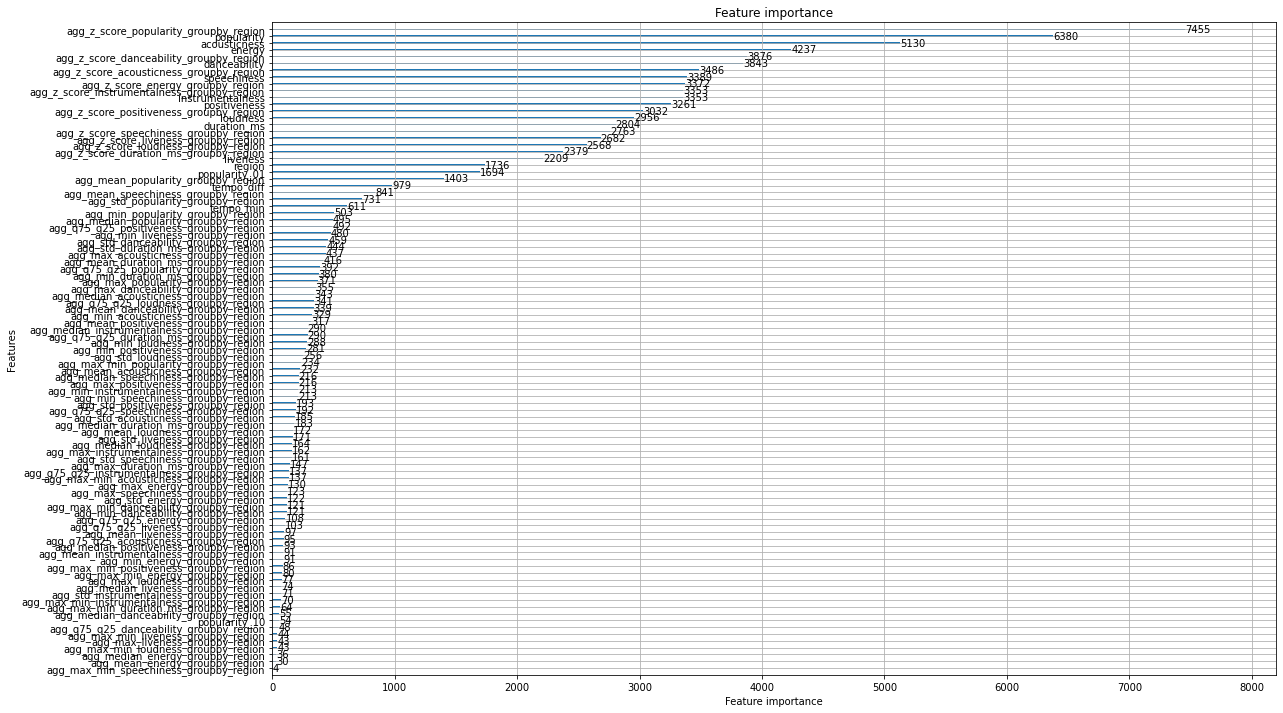

In [79]:
# Feature Importance
lgb.plot_importance(model, figsize=(18, 12))

In [80]:
# feature importanceが0の特徴量
X_train.columns[np.where(model.feature_importance()==0)]

Index(['tempo_max', 'tempo_sum', 'tempo_mean'], dtype='object')